In [1]:
import sys; sys.path.insert(0, '..')

import pandas as pd
import fragmentAndSimulate as fas
import spectrumVis
import calcIsotopologues as ci
import copy
import json
from tqdm import tqdm

import readInput as ri
import solveSystem as ss
import basicDeltaOperations as op

import matplotlib.pyplot as plt

In [2]:
MASS_CHANGE = {'13C': 13.00335484 - 12,
            '15N': 15.00010889 - 14.003074,
            'D': 2.014101778 - 1.007825032,
            '17O': 16.99913175 - 15.99491462,
            '18O': 17.9991596 - 15.99491462,
            '33S': 32.9714589 - 31.97207117,
            '34S':33.96786701 - 31.97207117,
            '36S':35.96708707 - 31.97207117}
              
def process_fragment_column(col, fragSubset, molecularDf, fragmentationDictionary, renameCols):
    '''
    Read and process a single fragment column. Helper function for moleculeFromCsv.

    Inputs: 
        col: A string, format like 'Fragment 44' or 'Fragment 44_01'.
        fragSubset: A list of fragment names, like ['44','full']
        molecularDf: The molecular DataFrame
        fragmentationDictionary: A dictionary specifying the fragments and their geometries
        renameCols: A dictionary, where keys are the column names in the input csv and values are new desired column names for the molecular Dataframe

    Outputs:
        fragmentationDictionary, molecularDf, renameCols

        All as above, but either filled with more information for frags in fragSubset (fragmentationDictionary and renameCols) or with information removed (molecularDf, if there are fragments not in 'fragSubset').     
    '''
    #Get just the fragment name
    newName = col.split(' ')[1]
    #fragments could be given as 44_01, 44_02, or just as 44; split into cases
    if '_' not in newName:
        #If the fragment is desired, fill in the dictionary
        if newName in fragSubset:
            fragmentationDictionary[newName] = {'01':{'subgeometry':list(molecularDf[col]),'relCont':1}}
        #otherwise, drop it
        else:
            molecularDf.drop(columns=col, inplace=True)

    else:
        #In this format, split into parent frag name and number
        parentFrag, geometryNumber = newName.split('_')
        #If the fragment is desired, fill in the dictionary
        if parentFrag in fragSubset:
            renameCols[col] = newName
            fragmentationDictionary[parentFrag] = {geometryNumber:{'subgeometry':list(molecularDf[col]), 'relCont':1}}
        #otherwise, drop it
        else:
            molecularDf.drop(columns=col, inplace=True)

    return fragmentationDictionary, molecularDf, renameCols

def otherFragmentReps(fragmentationDictionary, molecularDf):
    """
    Computes alternative representations of the fragments for easier processing.

    Inputs:
        fragmentationDictionary: A dictionary specifying the fragments and their geometries

    Outputs:
        expandedFrags: An ATOM depiction of each fragment, where an ATOM depiction has one entry for each atom (rather than for each site). See fragmentAndSimulate for details.
        fragSubgeometryKeys: A list of strings, e.g. 44_01, 44_02, corresponding to each subgeometry of each fragment. A fragment will have multiple subgeometries if there are multiple fragmentation pathways to form it.
    """
    condensedFrags = []
    fragSubgeometryKeys = []
    for fragKey, subFragDict in fragmentationDictionary.items():
        for subFragNum, subFragInfo in subFragDict.items():
            #for each subgeometry, get which sites it samples and its key. Add to list.
            condensedFrags.append(subFragInfo['subgeometry'])
            fragSubgeometryKeys.append(fragKey + '_' + subFragNum)

    #Expand to ATOM depictions of the fragments.
    expandedFrags = [fas.expandFrag(x, molecularDf['Number']) for x in condensedFrags]

    return expandedFrags, fragSubgeometryKeys

def moleculeFromCsv(path, deltas = False, fragSubset = None):
    '''
    Reads in a .csv file to get basic information about that molecule.

    Inputs:
        path: a string locating the .csv, e.g. 'Example Input.csv'
        fragSubset: A list of fragments to include. Defaults to None, in which case it is filled programatically to contain all fragments. 

    Outputs:
        initializedMolecule: A dictionary, containing:

            molecularDataFrame: A dataframe containing basic information about the molecule. 
            expandedFrags: An ATOM depiction of each fragment, where an ATOM depiction has one entry for each atom (rather than for each site). See fragmentAndSimulate for details.
            fragSubgeometryKeys: A list of strings, e.g. 44_01, 44_02, corresponding to each subgeometry of each fragment. A fragment will have multiple subgeometries if there are multiple fragmentation pathways to form it.
            fragmentationDictionary: A dictionary like the allFragments variable, but only including the subset of fragments selected by fragSubset.
    '''
    #Read csv
    molecularDf = pd.read_csv(path, index_col='Site Names')
    molecularDf.index.name = None

    #Columns must be renamed from the input csv to the format the code expects. We add to this in 'process_fragment_column'.
    renameCols = {'Element': 'IDS', 'Number Atoms': 'Number'}
    molecularDf.rename(columns=renameCols, inplace=True)

    #Fill in programatically in the default case
    if fragSubset == None:
        fragSubset = [col.split(' ')[1] for col in molecularDf.columns if 'Fragment' in col]

    #Fill a dictionary with the fragment information and which sites each fragment samples
    fragmentationDictionary = {}
    for col in molecularDf.columns:
        #get fragment columns
        if 'Fragment' in col:
            molecularDf[col] = molecularDf[col].replace(0, 'x')
            fragmentationDictionary, molecularDf, renameCols = process_fragment_column(col, fragSubset, molecularDf, fragmentationDictionary, renameCols)
        
        #calculate some other objects relating to fragments that are used in computations
        expandedFrags, fragSubgeometryKeys = otherFragmentReps(fragmentationDictionary, molecularDf)

    #rename the columns
    molecularDf.rename(columns=renameCols, inplace=True)

    if not deltas:
        molecularDf['deltas'] = molecularDf['Standard 1 Delta Values']
    else:
        molecularDf['deltas'] = deltas
    #Construct output
    initializedMolecule = {'molecularDataFrame':molecularDf,
                           'expandedFrags':expandedFrags,
                           'fragSubgeometryKeys':fragSubgeometryKeys,
                           'fragmentationDictionary':fragmentationDictionary}
    
    return initializedMolecule


def addClumps(byAtom, molecularDataFrame, clumpD):
    '''
    A function which adjusts the abundances of target isotopologues to include clumps. 

    Inputs:
        byAtom: A dictionary where keys are isotoplogues and values are dictionaries containing details about those isotopologues. 
        molecularDataFrame: A dataframe containing basic information about the molecule. 
        clumpD: Specifies information about clumps to add; otherwise the isotome follows the stochastic assumption. Currently works only for mass 1 substitutions (e.g. 1717, 1317, etc.) See ci.introduceClump for details.

    Outputs:
        byAtom: The same dictionary, with concentrations modified to include clumps. 
    '''
    stochD = copy.deepcopy(byAtom)
    
    for clumpNumber, clumpInfo in clumpD.items():
        byAtom = ci.introduceClump(byAtom, clumpInfo['Sites'], clumpInfo['Amount'], molecularDataFrame)
        
    for clumpNumber, clumpInfo in clumpD.items():
        ci.checkClumpDelta(clumpInfo['Sites'], molecularDataFrame, byAtom, stochD)

    return byAtom

def simulateMeasurement(initializedMolecule, abundanceThreshold = 0, UValueList = [],
                        massThreshold = 1, clumpD = {}, outputPath = None, disableProgress = True, calcFF = False, fractionationFactors = {}, omitMeasurements = {}, ffstd = 0.05, unresolvedDict = {}, outputFull = False):
    '''
    Simulates M+N measurements of an alanine molecule with input deltas specified by the input dataframe molecularDataFrame. 

    Inputs:
        molecularDataFrame: A dataframe containing basic information about the molecule. 
        expandedFrags: An ATOM depiction of each fragment, where an ATOM depiction has one entry for each atom (rather than for each site). See fragmentAndSimulate for details.
        fragSubgeometryKeys: A list of strings, e.g. 44_01, 44_02, corresponding to each subgeometry of each fragment. A fragment will have multiple subgeometries if there are multiple fragmentation pathways to form it.
        fragmentationDictionary: A dictionary like the allFragments variable, but only including the subset of fragments selected by fragSubset.
        abundanceThreshold: A float; Does not include measurements below this M+N relative abundance, i.e. assuming they will not be  measured due to low abundance. 
        UValueList: A list giving specific substitutions to calculate molecular average U values for ('13C', '15N', etc.)
        massThreshold: An integer; will calculate M+N relative abundances for N <= massThreshold
        clumpD: Specifies information about clumps to add; otherwise the isotome follows the stochastic assumption. Currently works only for mass 1 substitutions (e.g. 1717, 1317, etc.) See ci.introduceClump for details.
        outputPath: A string, e.g. 'output', or None. If it is a string, outputs the simulated spectrum as a json. 
        disableProgress: Disables tqdm progress bars when True.
        calcFF: When True, computes a new set of fractionation factors for this measurement.
        fractionationFactors: A dictionary, specifying a fractionation factor to apply to each ion beam. This is used to apply fractionation factors calculated previously to this predicted measurement (e.g. for a sample/standard comparison with the same experimental fractionation)
        omitMeasurements: omitMeasurements: A dictionary, {}, specifying measurements which I will not observed. For example, omitMeasurements = {'M1':{'61':'D'}} would mean I do not observe the D ion beam of the 61 fragment of the M+1 experiment, regardless of its abundance. 
        ffstd: A float; if new fractionation factors are calculated, they are pulled from a normal distribution centered around 1, with this standard deviation.
        unresolvedDict: A dictionary, specifying which unresolved ion beams add to each other.
        outputFull: A boolean. Typically False, in which case beams that are not observed are culled from the dictionary. If True, includes this information; this should only be used for debugging, and will likely break the solver routine. 
        
    Outputs:
        predictedMeasurement: A dictionary giving information from the M+N measurements. 
        MN: A dictionary where keys are mass selections ("M1", "M2") and values are dictionaries giving information about the isotopologues of each mass selection.
        fractionationFactors: The calculated fractionation factors for this measurement (empty unless calcFF == True)

    '''
    #Unpack initialized molecule dictionary
    molecularDataFrame = initializedMolecule['molecularDataFrame']
    expandedFrags = initializedMolecule['expandedFrags']
    fragSubgeometryKeys = initializedMolecule['fragSubgeometryKeys']
    fragmentationDictionary = initializedMolecule['fragmentationDictionary']

    byAtom = ci.inputToAtomDict(molecularDataFrame, disable = disableProgress)
    if clumpD != {}:
        byAtom = addClumps(byAtom, molecularDataFrame, clumpD)

    #bySub is an representation of data, a dictionary where keys are substitutions (e.g., '13C'), and values are their abundances. 
    bySub = ci.calcSubDictionary(byAtom, molecularDataFrame, atomInput = True)
    
    #Initialize Measurement output
    allMeasurementInfo = {}
    allMeasurementInfo = fas.UValueMeasurement(bySub, allMeasurementInfo, massThreshold = massThreshold,subList = UValueList)

    MN = ci.massSelections(byAtom, massThreshold = massThreshold)
    MN = fas.trackMNFragments(MN, expandedFrags, fragSubgeometryKeys, molecularDataFrame, unresolvedDict = unresolvedDict)
        
    predictedMeasurement, fractionationFactors = fas.predictMNFragmentExpt(allMeasurementInfo, MN, expandedFrags, fragSubgeometryKeys, molecularDataFrame, 
                                                 fragmentationDictionary, calcFF = calcFF, ffstd = ffstd,
                                                 abundanceThreshold = abundanceThreshold, fractionationFactors = fractionationFactors, omitMeasurements = omitMeasurements, unresolvedDict = unresolvedDict, outputFull = outputFull)
    
    if outputPath != None:
        output = json.dumps(predictedMeasurement)

        f = open(outputPath + ".json","w")
        f.write(output)
        f.close()
        
    return predictedMeasurement, MN, fractionationFactors

def massChangeVsUnsub(subKey):
    '''
    Given a subKey (e.g., 'D-D-13C'), returns the mass change caused by those isotope substitutions.

    Inputs:
        subKey: A string, like 'D-D-13C'.

    Outputs:
        mc: A float, the mass change associated with those rare isotope substitutions. 
    '''
    individualSubs = subKey.split('-')

    mc = 0
    for thisSub in individualSubs:
        mc += MASS_CHANGE[thisSub]

    return mc

def fullSpectrumVis(fullMolecule, molecularDataFrame, figsize = (8,4), massError = 0, lowAbundanceCutOff = 0, xlim = (), ylim = ()):
    '''
    Takes in some predicted spectral data for the full molecule and outputs a plot of that spectrum. Plots these as relative abundances. 

    (Note: The 'fullMolecule' input is typically from simulateMeasurement, which gives U values (e.g., 13C/Unsub) rather than abundances (e.g., 13C abundance). Because we renormalize to relative abundances and the Unsub in each denominator cancels, the spectrum is still correct). 

    Inputs:
        fullMolecule: A dictionary, where keys are substitutions (e.g., '' for Unsub, '13C', '13C-D'), and values are abundances. 
        molecularDataFrame: A dataframe containing basic information about the molecule. 
        figsize: Desired size of the output figure. 
        massError: Apply any mass error to the computed masses. 
        lowAbundanceCutOff: Do not show peaks below this abundance. 
        xlim: Override the xlimits of the plot
        ylim: Override the ylimits of the plot. 

    Outputs:
        None. Displays a plot.
    '''
    spectrumToPlot = {}

    #Calculate the mass of the unsubstituted isotopologue
    unsubStr = molecularDataFrame['Number'].sum() * '0'
    strSiteElements = ci.strSiteElements(molecularDataFrame)
    unsubMass = fas.computeMass(unsubStr, strSiteElements)

    #Go through the spectral data and pull out abundances. 
    for subKey, subData in fullMolecule.items():
        mass = unsubMass + massChangeVsUnsub(subKey) if subKey else unsubMass
        correctedMass = mass + massError

        # Initialize or update the dictionary for correctedMass
        spectrumToPlot.setdefault(correctedMass, {'U Value': 0, 'Sub': subKey})
        spectrumToPlot[correctedMass]['U Value'] = subData

    #Calculates the relative abundances, and places these, the masses, and substitutions into lists to plot. 
        totalAbundance = sum(item['U Value'] for item in spectrumToPlot.values())

        massPlot = []
        relAbundPlot = []
        subPlot = []
        for mass, data in spectrumToPlot.items():
            relAbundance = data['U Value'] / totalAbundance
            if relAbundance > lowAbundanceCutOff:
                massPlot.append(mass)
                relAbundPlot.append(relAbundance)
                subPlot.append(data['Sub'])
            
    #Constructs a figure; does not plot peaks below the relative abundance cut off. 
    fig, ax = plt.subplots(figsize = figsize)
    ax.vlines(massPlot, 0, relAbundPlot)

    # Set x-axis labels to mass and substitution info
    labels = [f"{round(mass, 5)}\n{sub}" for mass, sub in zip(massPlot, subPlot)]
    ax.set_xticks(massPlot)
    ax.set_xticklabels(labels, rotation=45)
    # Apply optional axis limits
    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)
    ax.set_ylabel("Relative Abundance")
            
    plt.show()

def MNSpectrumVis(molecularDataFrame, fragKey, predictedMeasurement, MNKey, MNDict, lowAbundanceCutOff = 0, massError = 0, xlim = (), ylim = ()):
    '''
    Visualizes the fragmented spectrum of an M+N experiment based on the abundances of fragment peaks.

    Inputs:
        molecularDataFrame: A dataframe containing basic information about the molecule. 
        fragKey: A string identifying the fragment, e.g. '133', '44'.
        predictedMeasurement: A dictionary giving information about the abundance of isotopic peaks in the fragment. See fragmentAndSimulate.predictMNFragmentExpt
        MNKey: A string identifying the mass selection to visualize; e.g. 'M1', 'M2'. This population of isotopologues is selected prior to fragmentation.
        MNDict: A dictionary; the keys are MNKeys ("M1", "M2") and the values are dictionaries containing the isotopologues present in each mass selection. See calcIsotopologues.massSelections
        lowAbundanceCutOff: Do not show peaks below this relative abundance.
        massError: In amu, shifts all observed peaks by this amount. 
        xlim: Set an xlim for the plot, as (xlow, xhigh)
        ylim: as xlim. 

    Outputs:
        None. Displays plot. 
    '''
    isotopologueData = predictedMeasurement[MNKey][fragKey]
    siteElements = ci.strSiteElements(molecularDataFrame)
    
    massPlot, relAbundPlot, subPlot = [], [], []
    for subKey, observation in isotopologueData.items():
        # Simplified isotopologue mass calculation
        isotopologues_df = pd.DataFrame.from_dict(MNDict[MNKey], orient='index')
        isotopologue_str = isotopologues_df.loc[isotopologues_df[fragKey + '_01 Subs'] == subKey,
                                                fragKey + '_01 Identity'].iloc[0]
        mass = fas.computeMass(isotopologue_str, siteElements) + massError

        if observation['Rel. Abundance'] > lowAbundanceCutOff:
            massPlot.append(mass)
            relAbundPlot.append(observation['Rel. Abundance'])
            subPlot.append(subKey)

    fig, ax = plt.subplots(figsize = (10,4))
    ax.vlines(massPlot, 0, relAbundPlot)

    ax.set_xticks(massPlot)
    labels = [str(round(x,5)) +'\n' + y for x,y in zip(massPlot,subPlot)]
    ax.set_xticklabels(labels,rotation = 45)
    
    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)
    ax.set_ylabel("Relative Abundance")
    
    plt.show()

def plotOutput(simulationOutput, relativeDeltasActual):
    fig, ax = plt.subplots(figsize = (8,4))

    plt.scatter(range(len(relativeDeltasActual)),relativeDeltasActual, label = 'Actual', marker = 's', color = 'r')
    plt.errorbar(range(len(relativeDeltasActual)),simulationOutput['Relative Deltas'],simulationOutput['Relative Deltas Error'], fmt = 'o',c='k',capsize = 5,
                label = 'Computed')
    plt.legend()
    ax.set_xticks(range(len(relativeDeltasActual)))
    ax.set_xticklabels(simulationOutput.index, rotation = 45)
    ax.set_ylabel("$\delta_{STD}$")

def simulateSmpStd(path, deltasStd, deltasSmp, deltasStdAppx, abundanceThreshold = 0, UValueList = [], massThreshold = 1, clumpD = {}, outputPath = None, disableProgress = True, calcFF = False, fractionationFactors = {}, omitMeasurements = {}, ffstd = 0.05, unresolvedDict = {}, plot = True, MonteCarloN = 100, perturbTheoryOAmt = 0, MNErrors = 0, UValueError = 0, resultsFileName = 'output.csv', outputPrecision = 3):
    simArgs = {
    'abundanceThreshold': abundanceThreshold,
    'UValueList': UValueList,
    'massThreshold': massThreshold,
    'clumpD': clumpD,
    'outputPath': outputPath,
    'disableProgress': disableProgress,
    'calcFF': calcFF,
    'fractionationFactors': fractionationFactors,
    'omitMeasurements': omitMeasurements,
    'ffstd': ffstd,
    'unresolvedDict': unresolvedDict}

    thisStd = moleculeFromCsv(path, deltas = deltasStd)
    stdMeasurement, stdMNDict, stdFF = simulateMeasurement(thisStd, **simArgs)

    thisSmp = moleculeFromCsv(path, deltas = deltasSmp)
    smpMeasurement, smpMNDict, smpFF = simulateMeasurement(thisSmp, **simArgs)

    forwardModel = moleculeFromCsv(path, deltas = deltasStdAppx)
    forwardModelPredictions, MNDict, FF = simulateMeasurement(forwardModel,abundanceThreshold = 0,
                                                                        massThreshold = 1,
                                                                            unresolvedDict = {})

    processStandard = ri.readComputedData(stdMeasurement, error = MNErrors, theory = forwardModelPredictions)
    processSample = ri.readComputedData(smpMeasurement, error = MNErrors)
    UValuesSmp = ri.readComputedUValues(smpMeasurement, error = UValueError)

    OCorrection = ss.OValueCorrectTheoretical(forwardModelPredictions, processSample, massThreshold = 1)
    isotopologuesDict = fas.isotopologueDataFrame(MNDict, forwardModel['molecularDataFrame'])

    M1Results = ss.M1MonteCarlo(processStandard, processSample, OCorrection, isotopologuesDict,
                                forwardModel['fragmentationDictionary'], 
                                N = MonteCarloN, GJ = False, debugMatrix = False, 
                                perturbTheoryOAmt = perturbTheoryOAmt, disableProgress = disableProgress)

    processedResults = ss.processM1MCResults(M1Results, UValuesSmp, isotopologuesDict, forwardModel['molecularDataFrame'], UMNSub = ['13C'], disableProgress = disableProgress)

    simulationOutput = ss.updateSiteSpecificDfM1MC(processedResults, forwardModel['molecularDataFrame'])

    #output nice csv
    cleanSimulationOutput = simulationOutput.drop(['deltas','M1 M+N Relative Abundance', 'M1 M+N Relative Abundance Error', 'UM1','UM1 Error','Calc U Values','Calc U Values Error'], axis=1, inplace=False)
    #Round off decimals
    toRound = ['VPDB etc. Deltas', 'VPDB etc. Deltas Error', 'Relative Deltas','Relative Deltas Error']
    cleanSimulationOutput[toRound] = cleanSimulationOutput[toRound].round(decimals=outputPrecision) 

    cleanSimulationOutput.to_csv(resultsFileName, index=False)

    if plot:
        relativeDeltasActual = [op.compareRelDelta(atomID, delta1, delta2) for atomID, delta1, delta2 in zip(forwardModel['molecularDataFrame']['IDS'], deltasStd, deltasSmp)]

        plotOutput(simulationOutput, relativeDeltasActual)

    return simulationOutput

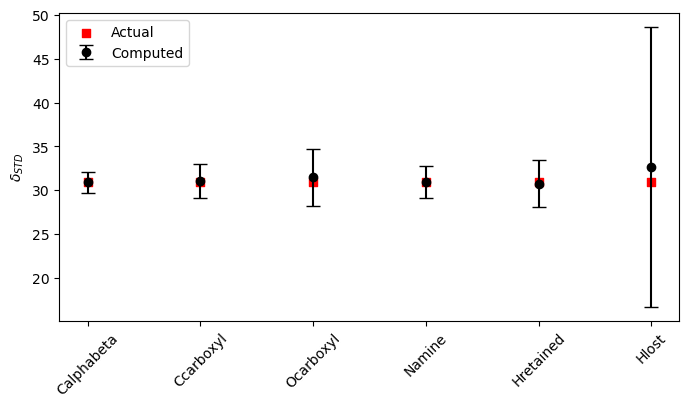

In [3]:
#TO DO Explicit error bars 

initializedMolecule = moleculeFromCsv("Example Input.csv")

#predictedMeasurement, MNDict, fractionationFactors = simulateMeasurement(moleculeFromCsv("Example Input.csv"), massThreshold = 5)

#fullSpectrumVis(predictedMeasurement['Full Molecule'], initializedMolecule['molecularDataFrame'], figsize = (8,4), massError = 0, lowAbundanceCutOff = 0, xlim = (), ylim = ())

#MNSpectrumVis(initializedMolecule['molecularDataFrame'], '44', predictedMeasurement, 'M1', MNDict, lowAbundanceCutOff = 0, massError = 0, xlim = (), ylim = ())

STD_DELTAS = [-30] * 6
SMP_DELTAS = [0] * 6
STD_DELTAS_APPROX = [-30] * 6

simulationOutput = simulateSmpStd('Example Input.csv', STD_DELTAS, SMP_DELTAS, STD_DELTAS_APPROX, abundanceThreshold = 0, UValueList = [], massThreshold = 1, clumpD = {}, outputPath = None, disableProgress = True, calcFF = False, fractionationFactors = {}, omitMeasurements = {}, ffstd = 0.05, unresolvedDict = {}, experimentalError = 0.001, resultsFileName = 'output.csv')